In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs

from anemoi.datasets.grids import cutout_mask
from anemoi.datasets import open_dataset

In [2]:
plt.style.use("~/nice.mplstyle")

In [3]:
def open_nested(trim_edge=0, min_distance_km=0):
    
    data_dir = "/pscratch/sd/t/timothys/nested-eagle/v0/data"
    return open_dataset(
        cutout=[
            {
                "join":
                [
                    f"{data_dir}/hrrr.analysis.zarr",
                    f"{data_dir}/hrrr.forecast.zarr",
                ],
                "trim_edge": trim_edge,
            },
            {
                "join":
                [
                    f"{data_dir}/gfs.analysis.zarr",
                    f"{data_dir}/gfs.forecast.zarr",
                ],
            },
        ],
        adjust="all",
        min_distance_km=min_distance_km,
    )

In [4]:
data = open_nested(trim_edge=(15, 16, 15, 16), min_distance_km=0)
data2 = open_nested(trim_edge=(15, 16, 15, 16), min_distance_km=15)
n_cutout = data.grids[0]

Dataset /pscratch/sd/t/timothys/nested-eagle/v0/data/hrrr.analysis.zarr has missing dates
Dataset /pscratch/sd/t/timothys/nested-eagle/v0/data/hrrr.forecast.zarr has missing dates
Dataset /pscratch/sd/t/timothys/nested-eagle/v0/data/gfs.analysis.zarr has missing dates
Dataset /pscratch/sd/t/timothys/nested-eagle/v0/data/gfs.forecast.zarr has missing dates
Dataset /pscratch/sd/t/timothys/nested-eagle/v0/data/hrrr.analysis.zarr has missing dates
Dataset /pscratch/sd/t/timothys/nested-eagle/v0/data/hrrr.forecast.zarr has missing dates
Dataset /pscratch/sd/t/timothys/nested-eagle/v0/data/gfs.analysis.zarr has missing dates
Dataset /pscratch/sd/t/timothys/nested-eagle/v0/data/gfs.forecast.zarr has missing dates


In [5]:
print(data.longitudes[:n_cutout].min(), data.longitudes[:n_cutout].max())
print(data.latitudes[:n_cutout].min(), data.latitudes[:n_cutout].max())

229.948723649617 294.70957081074306
23.593985793731036 50.35917944342358


In [6]:
print(data.longitudes[:n_cutout].min(), data.longitudes[:n_cutout].max())
print(data.latitudes[:n_cutout].min(), data.latitudes[:n_cutout].max())

229.948723649617 294.70957081074306
23.593985793731036 50.35917944342358


In [7]:
print(data.longitudes[0], data.longitudes[n_cutout-1])
print(data.latitudes[0], data.latitudes[n_cutout-1])

238.79933574943644 294.70957081074306
23.593985793731036 46.544797176707895


In [9]:
hmesh = xr.load_dataset("latentx2.hrrr15km.trim15-16.nc")
gmesh = xr.load_dataset("../global-mesh/latentx2.global1degree.nc")
#gmesh = xr.load_dataset("../global-mesh/latent-graduatedx2-4.global1degree.nc")

In [10]:
glon, glat = np.meshgrid(gmesh.lon, gmesh.lat)

Note, I've tested the `cropping_distance` and `neighbours` arguments.
Those defaults are good to go.

In [11]:
mask = cutout_mask(
        lats=hmesh.lat.values.flatten(),
        lons=hmesh.lon.values.flatten(),
        global_lats=glat.flatten(),
        global_lons=glon.flatten(),
        min_distance_km=0,
)

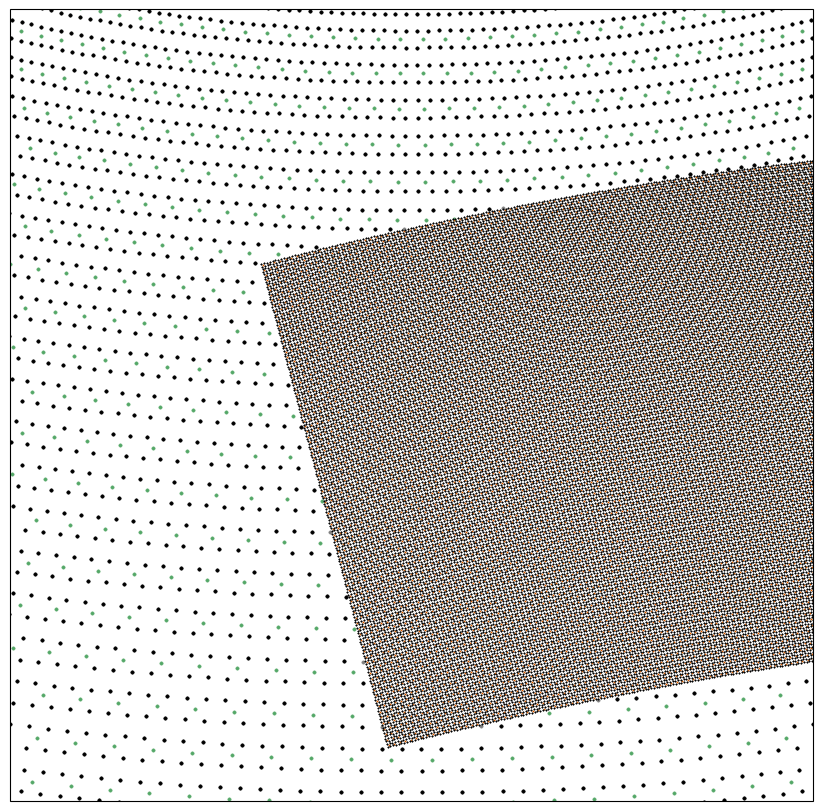

In [12]:
fig, ax = plt.subplots(
    1, 1,
    figsize=(12,8),
    subplot_kw={"projection": ccrs.Orthographic(central_longitude=-120, central_latitude=20)},
)

for x,y, x_d, y_d, x_dd, y_dd, s in zip(
    [glon.flatten()[mask], hmesh.lon.values.flatten()],
    [glat.flatten()[mask], hmesh.lat.values.flatten()],
    [data.longitudes[n_cutout:], data.longitudes[:n_cutout]],
    [data.latitudes[n_cutout:], data.latitudes[:n_cutout]],
    [data2.longitudes[n_cutout:], data2.longitudes[:n_cutout]],
    [data2.latitudes[n_cutout:], data2.latitudes[:n_cutout]],
    [6, 1],
):

    kw = {"transform": ccrs.PlateCarree(), "s": s}
    ax.scatter(x,y, **kw)
    ax.scatter(x_d, y_d, color="gray", **kw)
    ax.scatter(x_dd, y_dd, color="black", **kw)
ax.set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())

Anemoi cutout concatenates all LAM latitudes, then the global latitudes. Same for longitude.

In [13]:
cds = xr.Dataset(
    attrs={"n_cutout": n_cutout}
)

clon = np.concatenate([glon.flatten()[mask], hmesh.lon.values.flatten()])
cds["lon"] = xr.DataArray(
    clon,
    coords={"lon": clon},
)

clat = np.concatenate([glat.flatten()[mask], hmesh.lat.values.flatten()])
cds["lat"] = xr.DataArray(
    clat,
    coords={"lat": clat},
)

In [15]:
cds

<xarray.Dataset> Size: 490kB
Dimensions:  (lon: 30627, lat: 30627)
Coordinates:
  * lon      (lon) float64 245kB 1.0 3.0 5.0 7.0 9.0 ... 293.5 293.9 294.2 294.6
  * lat      (lat) float64 245kB -89.0 -89.0 -89.0 -89.0 ... 46.69 46.6 46.5
Data variables:
    *empty*
Attributes:
    n_cutout:  59040

In [16]:
np.savez("latentx2.combined.npz", lon=cds.lon.values, lat=cds.lat.values)